In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from losses.mapper import _get_contigious_to_original
def denormalize_image(img):
    """
    img = (h, w, c)
    """
    offset=(0.485, 0.456, 0.406)
    scale=(0.229, 0.224, 0.225)
    img[:, :, 0] += offset[0]
    img[:, :, 1] += offset[1]
    img[:, :, 2] += offset[2]
    
    img[:, :, 0] *= scale[0]
    img[:, :, 1] *= scale[1]
    img[:, :, 2] *= scale[2]
    return img

In [49]:
npy_path = "/depot/qqiu/data/vishal/tf-maskformer/predicted_npy"
which_img = 0
image_1 = np.load(os.path.join(npy_path, "input_img_"+str(which_img)+".npy"))[0]
target_masks = np.load(os.path.join(npy_path, "target_masks_"+str(which_img)+".npy"))[0]
predicted_masks = np.load(os.path.join(npy_path, "output_masks_"+str(which_img)+".npy"))[0]
target_labels = np.load(os.path.join(npy_path, "target_labels_"+str(which_img)+".npy"))[0]
predicted_labels = np.load(os.path.join(npy_path, "output_labels_"+str(which_img)+".npy"))[0]
#print shape of all the loaded arrays
print("image shape :", image_1.shape)
print("Target mask shape :", target_masks.shape)
print("Predicted mask shape :", predicted_masks.shape)
print("Targete labels shape :", target_labels.shape)
print("Predicted labels shape :", predicted_labels.shape)

image shape : (640, 640, 3)
Target mask shape : (100, 640, 640)
Predicted mask shape : (160, 160, 100)
Targete labels shape : (100,)
Predicted labels shape : (100, 134)


In [90]:
# post processing of masks
cat_id_map, is_thing_dict, _ = _get_contigious_to_original()
overlap_threshold = 0.1
object_detection_threshold = 0.7
mask_pred_b_resized =  tf.image.resize(predicted_masks, (640, 640), method=tf.image.ResizeMethod.BILINEAR)
mask_pred_b_sigmoid = tf.keras.activations.sigmoid(mask_pred_b_resized)
probs = tf.keras.activations.softmax(tf.convert_to_tensor(predicted_labels), axis=-1) 
scores = tf.reduce_max(probs, axis=-1) 
labels = tf.argmax(probs, axis=-1)
keep = tf.math.logical_and(tf.math.not_equal(labels, 0), scores > object_detection_threshold)
mask_pred_b_sigmoid = tf.transpose(mask_pred_b_sigmoid, (2, 0, 1)) # ( num_predictions, height, width)
            
# Give batch of predictions to the function
curr_masks = tf.boolean_mask(mask_pred_b_sigmoid, keep) # (num_predictions, height, width)
curr_classes = tf.boolean_mask(labels, keep) # (num_predictions)
curr_scores = tf.boolean_mask(scores, keep) # (num_predictions
cur_prob_masks = tf.reshape(curr_scores,(-1, 1, 1)) * curr_masks
height, width, num_masks = tf.shape(curr_masks)[1], tf.shape(curr_masks)[2], tf.shape(curr_masks)[0]
category_mask = tf.zeros((height, width), dtype=tf.int32)
instance_mask = tf.zeros((height, width), dtype=tf.int32)


_VOID_INSTANCE_ID = 0
instance_id = 0
cur_mask_ids = tf.argmax(cur_prob_masks, 0)

for k in range(tf.shape(curr_classes)[0]):
    pred_class = curr_classes[k]
   
    # isthing = self.is_thing_dict[self.cat_id_map[int(pred_class)]]

    binary_mask = tf.math.equal(cur_mask_ids, tf.cast(k, tf.int64))
    binary_mask = tf.cast(binary_mask, tf.int32)
    
    mask_area = tf.math.reduce_sum(binary_mask)
    original_area = tf.math.reduce_sum(tf.cast(curr_masks[k] >= 0.5, tf.int32))
    pred_class = curr_classes[k]
    class_score = curr_scores[k]

    if mask_area > 0 and original_area > 0:
        if mask_area / original_area < overlap_threshold:
            continue
        print("class label :", pred_class)
        category_id = cat_id_map.lookup(tf.cast(pred_class, tf.int32))
        binary_mask = tf.cast(binary_mask, tf.bool)
        category_mask = tf.where(binary_mask, category_id, category_mask)
        if tf.cast(is_thing_dict.lookup(category_id), tf.bool):
            instance_mask = tf.where(binary_mask, instance_id, instance_mask)
            instance_id += 1
        else:
            binary_mask = tf.cast(binary_mask, tf.bool)
            
            instance_mask = tf.where(binary_mask, _VOID_INSTANCE_ID, instance_mask)
        

class label : tf.Tensor(40, shape=(), dtype=int64)
class label : tf.Tensor(132, shape=(), dtype=int64)
class label : tf.Tensor(42, shape=(), dtype=int64)
class label : tf.Tensor(76, shape=(), dtype=int64)
class label : tf.Tensor(46, shape=(), dtype=int64)
class label : tf.Tensor(93, shape=(), dtype=int64)
class label : tf.Tensor(94, shape=(), dtype=int64)
class label : tf.Tensor(84, shape=(), dtype=int64)
class label : tf.Tensor(73, shape=(), dtype=int64)
class label : tf.Tensor(132, shape=(), dtype=int64)
class label : tf.Tensor(115, shape=(), dtype=int64)
class label : tf.Tensor(72, shape=(), dtype=int64)
class label : tf.Tensor(46, shape=(), dtype=int64)
class label : tf.Tensor(86, shape=(), dtype=int64)
class label : tf.Tensor(46, shape=(), dtype=int64)
class label : tf.Tensor(133, shape=(), dtype=int64)
class label : tf.Tensor(45, shape=(), dtype=int64)
class label : tf.Tensor(122, shape=(), dtype=int64)
class label : tf.Tensor(123, shape=(), dtype=int64)
class label : tf.Tensor(1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


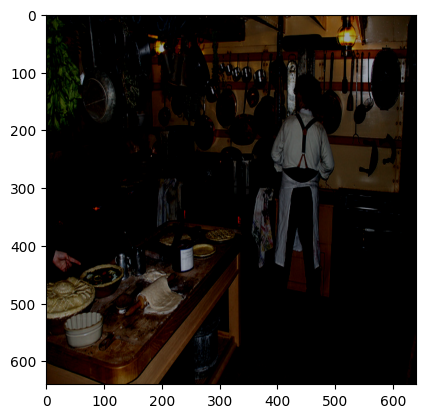

In [35]:
plt.imshow(denormalize_image(image_1[0]))

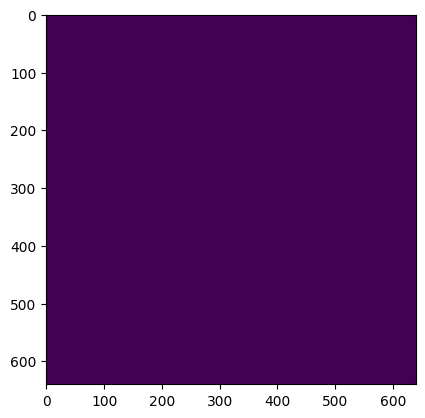

In [94]:
plt.imshow(category_mask == 124)

In [74]:
print(target_labels)

[  1.   1.  40.  42.  42.  44.  45.  46.  46.  46.  46.  51.  51.  51.
  52.  61.  70.  70.  72.  93. 111. 117. 121. 122. 123. 124. 129. 132.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


In [98]:
do_crop = tf.greater(tf.random.uniform([]), 0.3)
print(do_crop)

tf.Tensor(False, shape=(), dtype=bool)
